In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import albumentations  as A
import cv2
import pandas as pd
import ntpath
import random
from sklearn.metrics import accuracy_score

In [3]:
datadir = 'data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
dataset = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', 1)
dataset.head()

center  \
0  C:\Users\HP\Downloads\simulator-windows-64\data\IMG\center_2025_09_30_11_53_33_849.jpg   
1  C:\Users\HP\Downloads\simulator-windows-64\data\IMG\center_2025_09_30_11_53_33_954.jpg   
2  C:\Users\HP\Downloads\simulator-windows-64\data\IMG\center_2025_09_30_11_53_34_062.jpg   
3  C:\Users\HP\Downloads\simulator-windows-64\data\IMG\center_2025_09_30_11_53_34_168.jpg   
4  C:\Users\HP\Downloads\simulator-windows-64\data\IMG\center_2025_09_30_11_53_34_279.jpg   

                                                                                    left  \
0   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\left_2025_09_30_11_53_33_849.jpg   
1   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\left_2025_09_30_11_53_33_954.jpg   
2   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\left_2025_09_30_11_53_34_062.jpg   
3   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\left_2025_09_30_11_53_34_168.jpg   
4   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\left_2025_09_30_11_53_34_279.jpg   

                                                                                    right  \
0   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\right_2025_09_30_11_53_33_849.jpg   
1   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\right_2025_09_30_11_53_33_954.jpg   
2   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\right_2025_09_30_11_53_34_062.jpg   
3   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\right_2025_09_30_11_53_34_168.jpg   
4   C:\Users\HP\Downloads\simulator-windows-64\data\IMG\right_2025_09_30_11_53_34_279.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000079  
1  0.0       0.0       0.0      0.000078  
2  0.0       0.0       0.0      0.000078  
3  0.0       0.0       0.0      0.000079  
4  0.0       0.0       0.0      0.000078

In [4]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
dataset['center'] = dataset['center'].apply(path_leaf)
dataset['left'] = dataset['left'].apply(path_leaf)
dataset['right'] = dataset['right'].apply(path_leaf)
dataset.head()

center                              left  \
0  center_2025_09_30_11_53_33_849.jpg  left_2025_09_30_11_53_33_849.jpg   
1  center_2025_09_30_11_53_33_954.jpg  left_2025_09_30_11_53_33_954.jpg   
2  center_2025_09_30_11_53_34_062.jpg  left_2025_09_30_11_53_34_062.jpg   
3  center_2025_09_30_11_53_34_168.jpg  left_2025_09_30_11_53_34_168.jpg   
4  center_2025_09_30_11_53_34_279.jpg  left_2025_09_30_11_53_34_279.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2025_09_30_11_53_33_849.jpg  0.0       0.0       0.0      0.000079  
1  right_2025_09_30_11_53_33_954.jpg  0.0       0.0       0.0      0.000078  
2  right_2025_09_30_11_53_34_062.jpg  0.0       0.0       0.0      0.000078  
3  right_2025_09_30_11_53_34_168.jpg  0.0       0.0       0.0      0.000079  
4  right_2025_09_30_11_53_34_279.jpg  0.0       0.0       0.0      0.000078

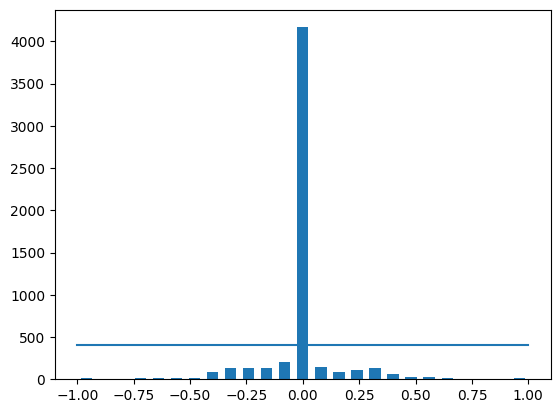

In [5]:
num_bins = 25
num_of_samples = 400
hist, bins = np.histogram(dataset['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist,width= 0.05)
plt.plot((np.min(dataset['steering']), np.max(dataset['steering'])), (num_of_samples, num_of_samples))

In [6]:
print('total data:', len(dataset))
print(dataset.shape)

total data: 5580
(5580, 7)


In [7]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(dataset['steering'])):
        if dataset['steering'][i] >= bins[j] and dataset['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[num_of_samples:]
    remove_list.extend(list_)
print('removed:', len(remove_list))
dataset.drop(dataset.index[remove_list], inplace=True)
print('remaining:', len(dataset))

removed: 3767
remaining: 1813


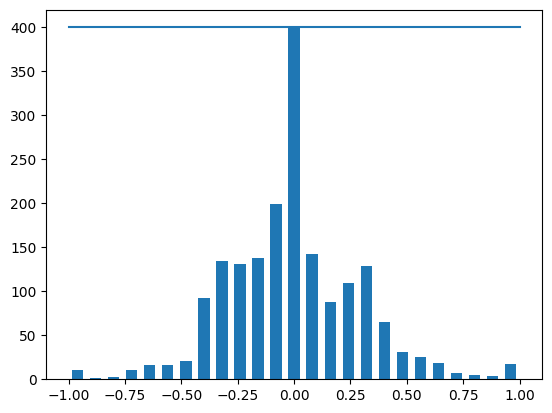

In [8]:
hist , _ = np.histogram(dataset['steering'], (num_bins))
plt.bar(center, hist , width= 0.05)
plt.plot((np.min(dataset['steering']), np.max(dataset['steering'])), (num_of_samples,num_of_samples))

In [9]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(dataset)):
    indexed_data = dataset.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [10]:
image_paths, steerings = load_img_steering(datadir + '/IMG', dataset)
image_paths = np.array([p.replace("\\", "/") for p in image_paths])




C:\Users\HP\AppData\Local\Temp\ipykernel_7356\3069035682.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
C:\Users\HP\AppData\Local\Temp\ipykernel_7356\3069035682.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
C:\Users\HP\AppData\Local\Temp\ipykernel_7356\3069035682.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

In [11]:
image_paths

array(['data/IMG/center_2025_09_30_11_53_34_062.jpg',
       'data/IMG/left_2025_09_30_11_53_34_062.jpg',
       'data/IMG/right_2025_09_30_11_53_34_062.jpg', ...,
       'data/IMG/center_2025_09_30_12_10_37_833.jpg',
       'data/IMG/left_2025_09_30_12_10_37_833.jpg',
       'data/IMG/right_2025_09_30_12_10_37_833.jpg'],
      shape=(5439,), dtype='<U43')

In [12]:
steerings

array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15], shape=(5439,))

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size=0.2, random_state=6)
print(f'Training data: {len(X_train)}\n Valid Samples: {len(X_valid)}')

Training data: 4351
 Valid Samples: 1088


Text(0.5, 1.0, 'Validation set')

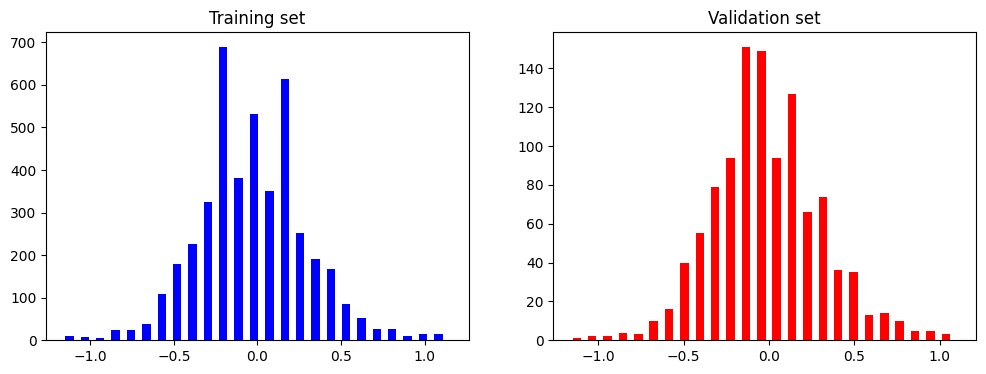

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'zoomed image')

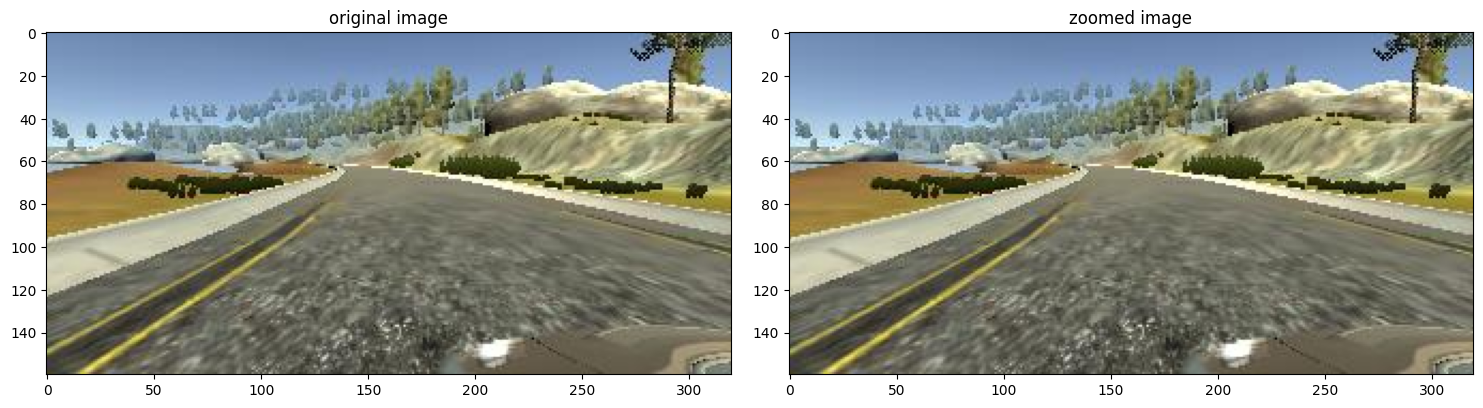

In [15]:
#increases dataset variety without collecting new data. 
#model learns to handle slightly different perspectives.
zoom_transform = A.Compose([
    A.Affine(scale=(1.0, 1.3))
])
def zoom(image):
    augmented = zoom_transform(image=image)
    return augmented['image']

   
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed image')

Text(0.5, 1.0, 'Panned Image')

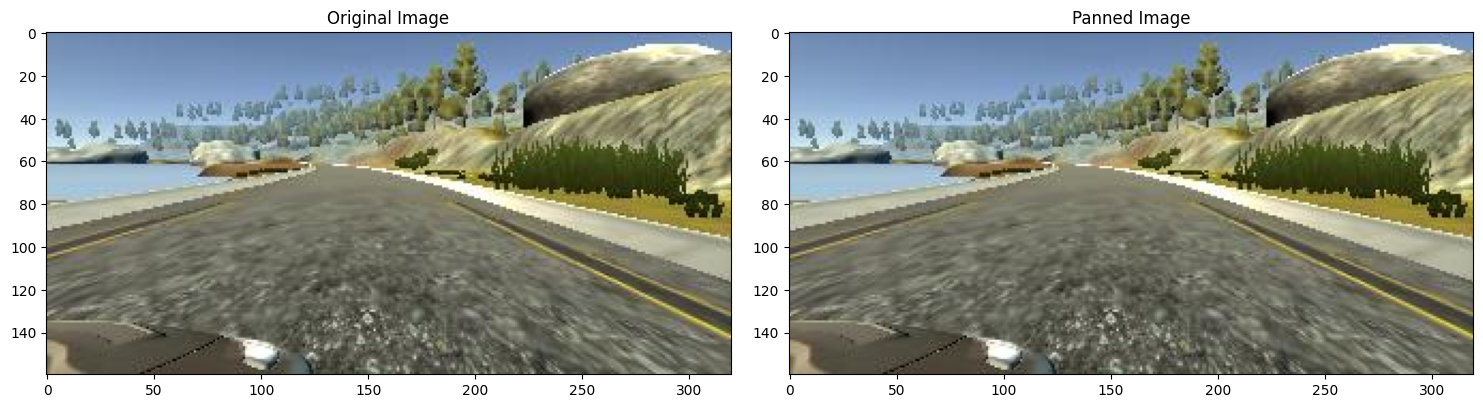

In [16]:
pan_transform = A.Compose([
    A.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
])
def pan(image):
    augmented = pan_transform(image=image)
    return augmented['image']

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

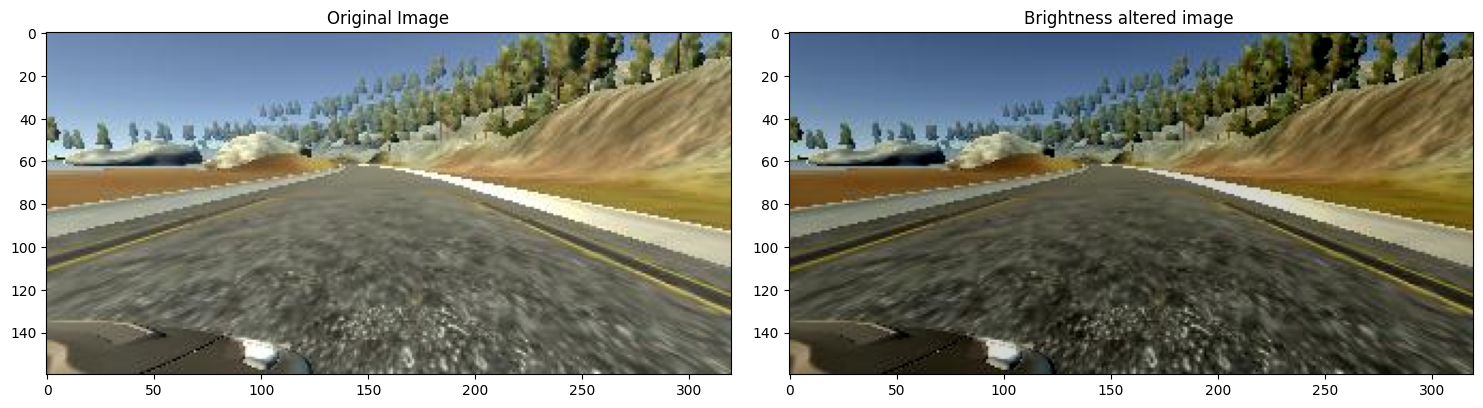

In [17]:
brightness_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=1.0)
])
def img_random_brightness(image):
    augmented = brightness_transform(image=image)
    return augmented['image']

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)


fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ') 

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2409093')

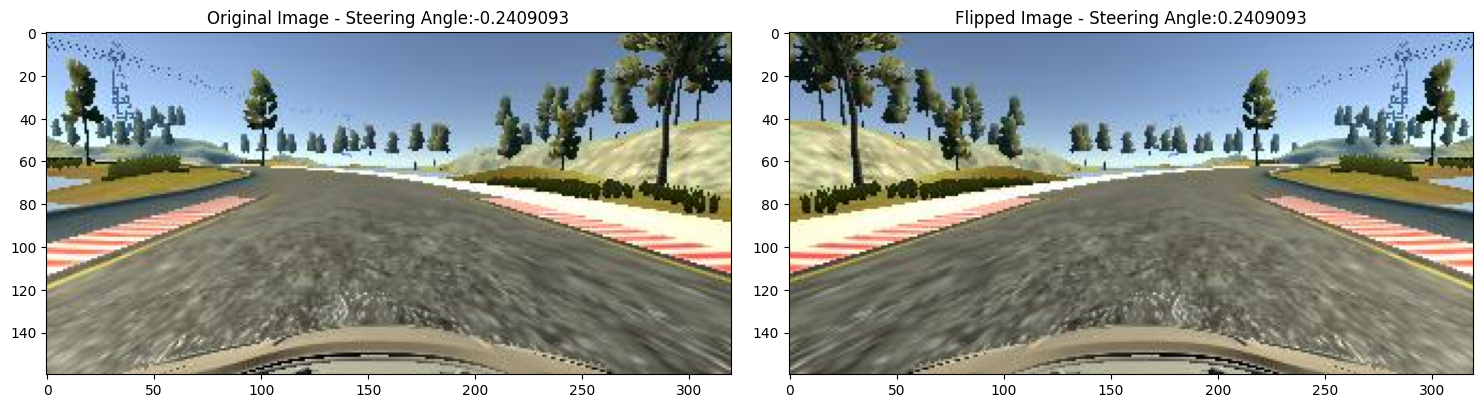

In [18]:

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [19]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

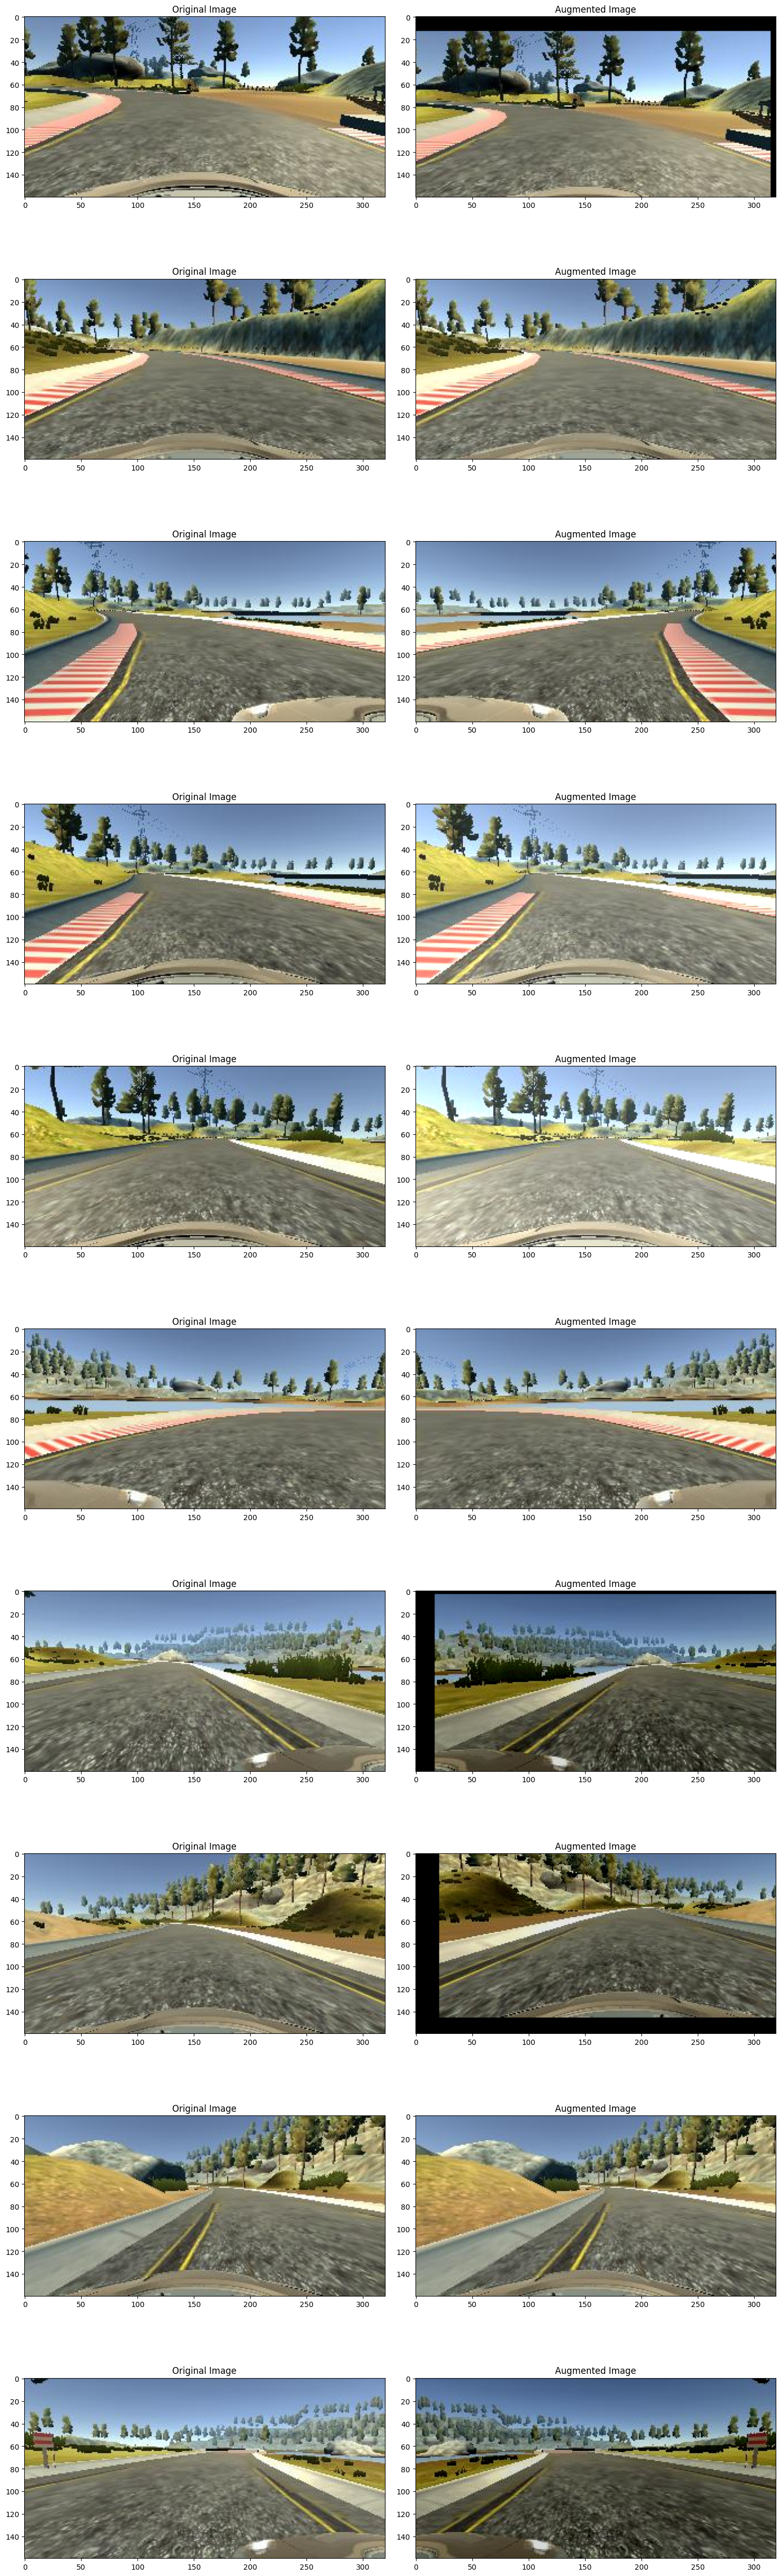

In [20]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [21]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

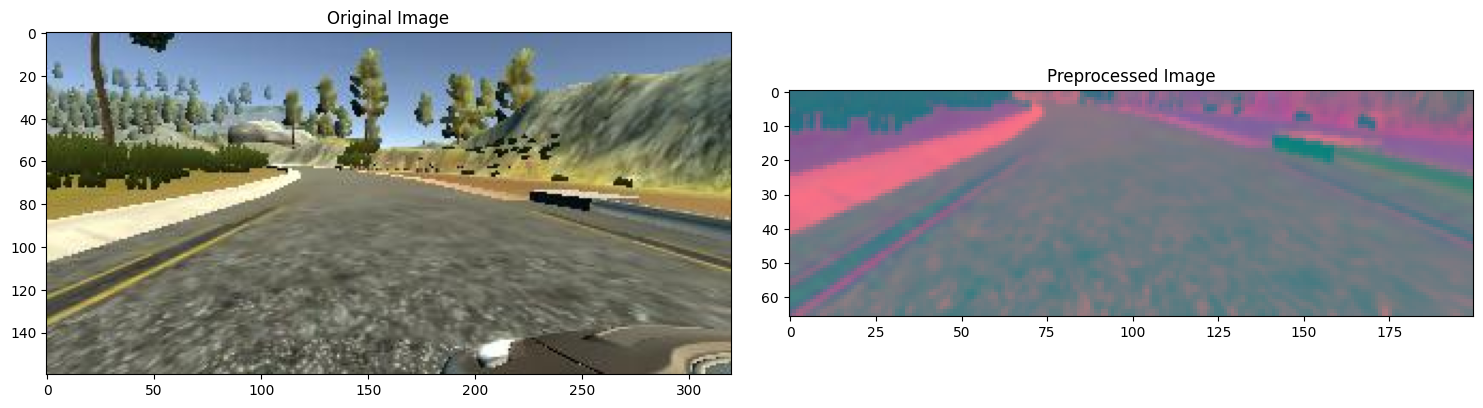

In [22]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [23]:
!nvidia-smi

Fri Oct  3 12:35:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 577.03                 Driver Version: 577.03         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   37C    P0             13W /   30W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [25]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

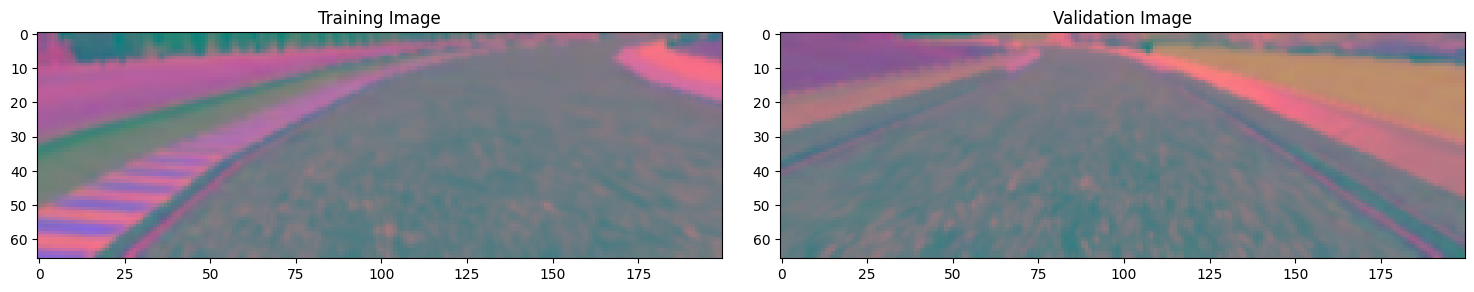

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [47]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  #model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 1, 18, 64)      │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,443 (1.01 MB)

 Trainable params: 264,443 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [49]:
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPUs detected: {gpu_devices}")
    print("TensorFlow is configured to use the GPU.")
else:
    print("No GPUs detected. TensorFlow will run on CPU.")

No GPUs detected. TensorFlow will run on CPU.


In [50]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=100,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  callbacks=callback,
                                  shuffle = 1)

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 136s 446ms/step - loss: 0.1145 - val_loss: 0.0743
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 106s 354ms/step - loss: 0.0827 - val_loss: 0.0669
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 104s 349ms/step - loss: 0.0782 - val_loss: 0.0691
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 104s 349ms/step - loss: 0.0772 - val_loss: 0.0618
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 113s 378ms/step - loss: 0.0730 - val_loss: 0.0658
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 111s 373ms/step - loss: 0.0728 - val_loss: 0.0604
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 103s 345ms/step - loss: 0.0715 - val_loss: 0.0603
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1877s 6s/step - loss: 0.0714 - val_loss: 0.0624
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 111s 372ms/step - loss: 0.0676 - val_loss: 0.0600
Epoch 10/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 111s 369ms/step - loss: 0.0674 - val_loss: 0.0533
Epoch 11/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 118s 394ms/step - loss: 0.0652 - val_loss: 0.0520

Text(0.5, 0, 'Epoch')

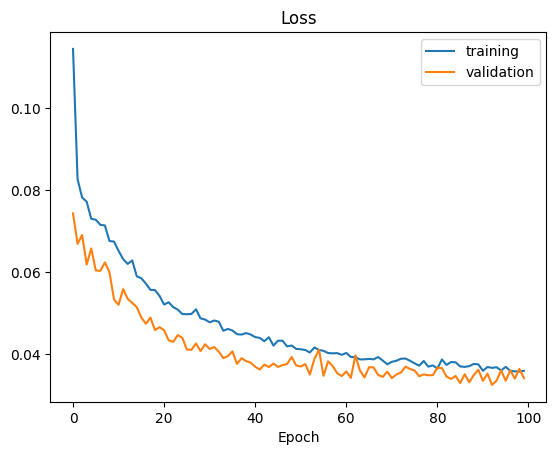

In [51]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')


In [52]:
model.save("model.h5")
